# Demo: Finite Difference Methods for the Poisson Equation on a Square

In [1]:
import numpy as np

from scipy import sparse
import scipy.sparse.linalg
import scipy.linalg

import matplotlib.pyplot as plt
import cmocean
import cmocean.cm as cmo

import time

# Update 07/18/22: got retina working with updates thanks to 
# https://stackoverflow.com/questions/54312924/what-is-matplotlibs-retina-display-mode
%matplotlib inline
%config InlineBackend.figure_format='retina'

TODO: currently very incomplete! 

For details on stability and accuracy, see section 3.4 of Leveque. 

The top-to-bottom, left-to-right convention is used to label the lattice points, since this plays nicely with NumPy's $\texttt{meshgrid}$ conventions. 

We also need a subroutine for building our discrete Laplacian (which depends on $L$ and $N$) as a sparse matrix (which is why we need to load the SciPy $\texttt{sparse}$ and $\texttt{scipy.sparse.linalg}$ packages). 

In [2]:
def laplacian(L, N):

    # Define (uniform) grid spacing. We put this into the matrix A at the final step. 
    h = L/(N+1) 
    
    # Prescribe nonzero diagonals of A
    A_0 = -1.*np.ones(N**2, dtype=float)
            
    A_1 = np.ones(N**2-1, dtype=float)
    
    A_1[N-1::N] = 0.
    
    A_1*=0.25
            
    A_N = 0.25*np.ones(N**2-N, dtype=float)
    
    # Create the sparse matrix A
    A = sparse.diags([A_0, A_1, A_1, A_N, A_N], [0, 1, -1, N, -N], shape=(N**2,N**2))
    
    A = sparse.csr_matrix(A) # make sure that A is a sparse matrix! 
    
    return  A

In [3]:
print(laplacian(1,3).toarray())

[[-1.    0.25  0.    0.25  0.    0.    0.    0.    0.  ]
 [ 0.25 -1.    0.25  0.    0.25  0.    0.    0.    0.  ]
 [ 0.    0.25 -1.    0.    0.    0.25  0.    0.    0.  ]
 [ 0.25  0.    0.   -1.    0.25  0.    0.25  0.    0.  ]
 [ 0.    0.25  0.    0.25 -1.    0.25  0.    0.25  0.  ]
 [ 0.    0.    0.25  0.    0.25 -1.    0.    0.    0.25]
 [ 0.    0.    0.    0.25  0.    0.   -1.    0.25  0.  ]
 [ 0.    0.    0.    0.    0.25  0.    0.25 -1.    0.25]
 [ 0.    0.    0.    0.    0.    0.25  0.    0.25 -1.  ]]


In [4]:
def poisson_solve(L, N, RHS, verbose = True, solver = 'direct'):
    
    # first, reshape forcing term from a grid function to an N^2 x 1 array: 
    RHS = np.reshape(RHS[1:-1,1:-1], N**2)
    #NOTE: RHS must include its boundary values by default, even though only the 
    #interior ones are used. 

    # Assemble Laplacian matrix, as a csr_matrix
    A = laplacian(L, N)

    # We use Jacobi preconditioning to give our sparse solver a bit
    # of an easier time (lower condition number of A). This means the discrete
    # Laplacian A does not include any information on the grid spacing h: all
    # mention of h is moved to the RHS
    h = L/(N+1)
    
    f = 0.25*(h**2)*RHS
    
    # Solve the resulting linear system, using specification of our solver. 
    start=time.time()
    
    if solver == 'direct':
    
        u_guess = sparse.linalg.spsolve(A, f) # make sure to use the sparse solver!
        
    elif solver == 'cg':
        
        u_guess = sparse.linalg.cg(A,f, x0=np.zeros(N**2, dtype=float))[0]
        
    else: 
        
        raise Exception('Must specify a valid solver, either "direct" or "cg"')
                
    end=time.time()

    solve_time = end-start
    
    if verbose == True: 
        
        #print('Condition number = %.2E' % np.linalg.cond(A.toarray()))
        print('Solve time = %.4f' % solve_time, 's')
        
    else: 
        
        pass
    
    #Finally, reshape output into a grid function
    u_guess = np.reshape(u_guess, (N,N))
    
    return u_guess

We let $\Omega$ denote the square 
$$
\Omega = [0,L]\times [0,L] \subseteq \mathbb{R}^2. 
$$
We solve the BVP

\begin{equation}
\left\{
\begin{aligned}
\Delta  u &= f(x,y)  
\\
u|_{\partial \Omega} &= 0. 
\end{aligned}
\right.
\end{equation}

for various choice of $f(x,y)$. For starters, we pick 

$$
f(x,y) = x\left(x-L\right) + y\left(y-L\right)
$$

for which we readily verify the (unique!) exact solution is 

$$ 
u(x,y) = \frac12 xy\left(x-L\right)\left(y-L\right).
$$

We choose $L=4$ so that $u$ is roughly $\mathcal{O}(1)$, which in turns makes the scale of a filled contour plot of $u$ easy to read. 

In [29]:
L = 4. 

N = 64

x =np.linspace(0,L,N+2)
y =np.linspace(0,L,N+2)
xx, yy = np.meshgrid(x, y, sparse=True)

# define the actual solution and forcing term as grid functions. 
u_true = 0.5*xx*yy*(xx-L)*(yy-L)
RHS = xx*(xx-L) + yy*(yy-L)

In [30]:
u_guess = poisson_solve(L, N, RHS, verbose = True, solver='direct')

Solve time = 0.0149 s


In [31]:
error =  np.linalg.norm(u_guess-u_true[1:-1, 1:-1], ord=2)
print('L^2-Norm Error = %.2E'% error) 

L^2-Norm Error = 2.43E-12


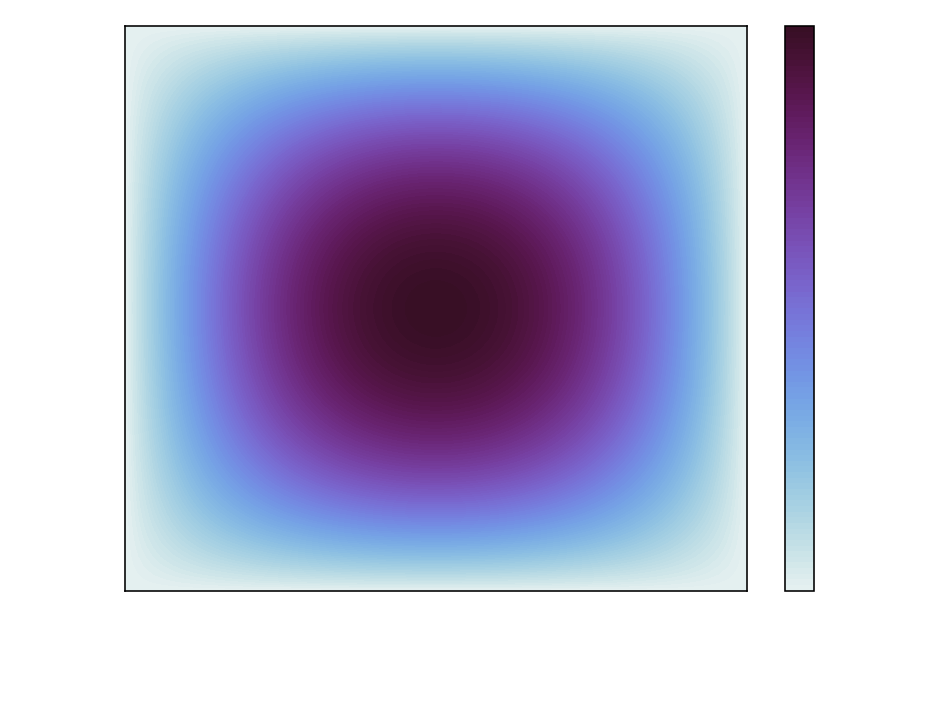

In [32]:
# MAKE FILLED CONTOUR PLOT OF SOLN
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

fig = plt.figure()

z = np.zeros((N+2, N+2), dtype=float)
z[1:-1,1:-1] = u_guess

CF = plt.contourf(x,y,z, levels=100, cmap = cmo.dense)

# axis labels
plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"$y$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')

# make colorbar
cbar = plt.colorbar(CF,  format='%.1f')
cbar.ax.tick_params(labelsize=16, color='w') 
plt.clim(0,np.amax(z))
cbar.ax.set_ylabel(r'$u(x,y)$', fontsize=26, color='w')

# the final piece of the colorbar defn is to change the colorbar ticks to an acceptable color.
# This is not so easy, and relies on the thread at
# https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color='w')

fig.set_size_inches((4/3)*5, 5)

plt.tight_layout()

plt.show()

In [38]:
L = 4.

for N in 2**np.arange(2,10): 
    
    x =np.linspace(0,L,N+2)
    y =np.linspace(0,L,N+2)
    xx, yy = np.meshgrid(x, y, sparse=True)

    # define the actual solution and forcing term as grid functions. 
    u_true = 0.5*xx*yy*(xx-L)*(yy-L)
    RHS = xx*(xx-L) + yy*(yy-L)
    
    u_guess = poisson_solve(L, N, RHS, verbose = True, solver='direct')
    
    error =  np.linalg.norm(u_guess-u_true[1:-1, 1:-1], ord=2)
    
    print('L^2-Norm Error = %.2E' % error) 

Solve time = 0.0012 s
L^2-Norm Error = 3.40E-15
Solve time = 0.0008 s
L^2-Norm Error = 7.50E-15
Solve time = 0.0013 s
L^2-Norm Error = 8.58E-14
Solve time = 0.0053 s
L^2-Norm Error = 6.91E-13
Solve time = 0.0269 s
L^2-Norm Error = 2.43E-12
Solve time = 0.0560 s
L^2-Norm Error = 2.59E-11
Solve time = 0.8185 s
L^2-Norm Error = 2.16E-10
Solve time = 5.6593 s
L^2-Norm Error = 1.68E-09


TODO: add discussion on how the theoretical $h^2$ convergence rate is spoiled by ill-conditioning, and give some indication how a refinement study can help address this problem.... work this in later!

Solve time = 0.1101 s


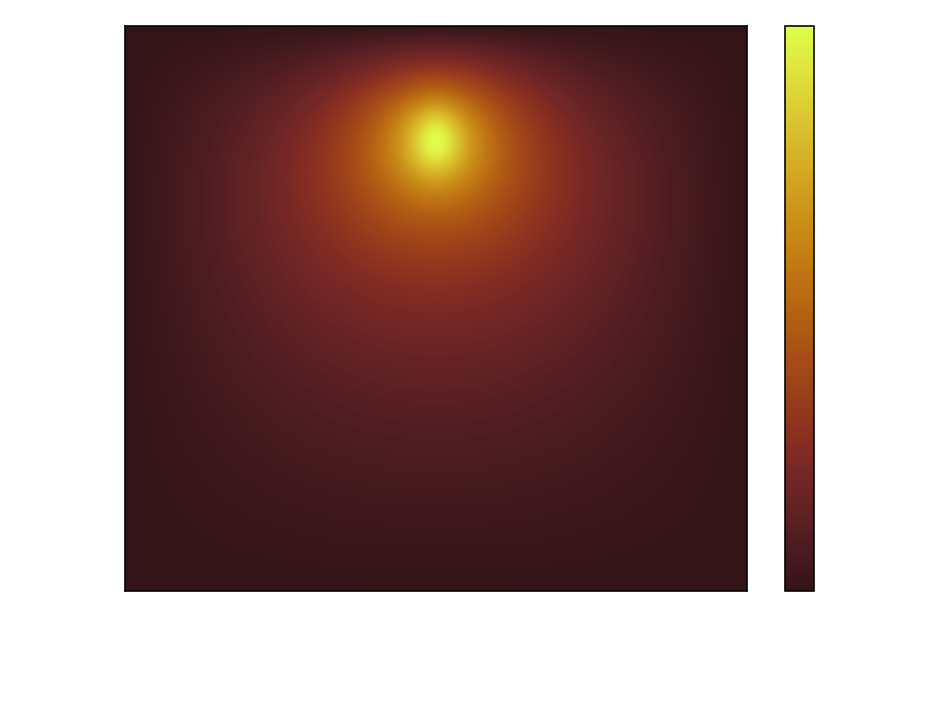

In [34]:
L = 4.

N = 128

x =np.linspace(0,L,N+2)
y =np.linspace(0,L,N+2)
xx, yy = np.meshgrid(x, y, sparse=True)

# define forcing term as a grid functions. 
RHS = -100.*np.exp(-100.*(xx-0.5*L)**2-25.*(yy-0.8*L)**2)

# optionally add some white noise to forcing if you want
#random_forcing = 100.*5e-1*sparse.random(N+2, N+2, density=0.4, data_rvs=np.random.randn).toarray()
#RHS+=random_forcing
    
u_guess = poisson_solve(L, N, RHS, verbose = True, solver='direct')
    
#Plotting stuff
fig = plt.figure()

z = np.zeros((N+2, N+2), dtype=float)
z[1:-1,1:-1] = u_guess

CF = plt.contourf(x,y,z, levels=200, cmap = cmo.solar)

# axis labels
plt.xlabel(r"$x$", fontsize=26, color = 'w')
plt.ylabel(r"$y$", fontsize=26, color='w')

plt.tick_params(axis='x', which='both', top='off', color = 'w')
plt.xticks(fontsize=18, rotation=0, color = 'w')
plt.tick_params(axis='y', which='both', right='off', color = 'w')
plt.yticks(fontsize=18, rotation=0, color = 'w')

# make colorbar
cbar = plt.colorbar(CF,  format='%.1f')
cbar.ax.tick_params(labelsize=16, color='w') 
#plt.clim(0,np.amax(z))
cbar.ax.set_ylabel(r'$u(x,y)$', fontsize=26, color='w')

# the final piece of the colorbar defn is to change the colorbar ticks to an acceptable color.
# This is not so easy, and relies on the thread at
# https://stackoverflow.com/questions/9662995/matplotlib-change-title-and-colorbar-text-and-tick-colors
cbytick_obj = plt.getp(cbar.ax.axes, 'yticklabels')                
plt.setp(cbytick_obj, color='w')

fig.set_size_inches((4/3)*5, 5)

plt.tight_layout()

plt.show()